In [1]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Install PySpark
!pip install pyspark

# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, when
from pyspark.ml.feature import StringIndexer, RFormula, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col, abs as spark_abs
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Task2_RF_AttackLabel") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session Created Successfully!")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


26/02/22 14:18:53 WARN Utils: Your hostname, ijuwon-ui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.8 instead (on interface en0)
26/02/22 14:18:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/22 14:18:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/22 14:18:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/02/22 14:18:54 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Spark Session Created Successfully!


In [2]:
def load_and_prep_spark_data():
    train_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_training-set.csv'
    test_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_testing-set.csv'
    
     # Juwon's Local file path
    test_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_testing-set.csv'
    train_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_training-set.csv'

    print("Loading data into Spark...")
    df_train_orig = spark.read.csv(train_path, header=True, inferSchema=True)
    df_test_orig = spark.read.csv(test_path, header=True, inferSchema=True)

    # 1. Combine and Drop
    df_full = df_train_orig.unionByName(df_test_orig).drop('id', 'attack_cat')

    df_full = df_full.withColumn("pkt_ratio", (col("spkts") + 1) / (col("dpkts") + 1))
    df_full = df_full.withColumn("ttl_gap", spark_abs(col("sttl") - col("dttl")))

    # Print Feature Info (Match Task 1 style)
    feature_cols = [c for c in df_full.columns if c != 'label']
    print(f"Features used for training ({len(feature_cols)} total):")
    print(feature_cols)
    print("-" * 50)

    # 2. Stratified Split
    zeros = df_full.filter(col("label") == 0)
    ones = df_full.filter(col("label") == 1)
    train_0, val_0, test_0 = zeros.randomSplit([0.7, 0.15, 0.15], seed=42)
    train_1, val_1, test_1 = ones.randomSplit([0.7, 0.15, 0.15], seed=42)

    train_data = train_0.union(train_1)
    val_data = val_0.union(val_1)
    test_data = test_0.union(test_1)

    print(f"Data Loaded and Split: Train: {train_data.count()}, Val: {val_data.count()}, Test: {test_data.count()}")
    return train_data, val_data, test_data

train_df, val_df, test_df = load_and_prep_spark_data()

Loading data into Spark...
Features used for training (44 total):
['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'pkt_ratio', 'ttl_gap']
--------------------------------------------------


26/02/22 14:18:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Data Loaded and Split: Train: 180973, Val: 38573, Test: 38127


In [3]:
def train_spark_rf(train_data, val_data):
# 1. Identify Columns
    categorical_cols = ['proto', 'service', 'state']
    # These are the columns we manually added in load_and_prep_spark_data
    extra_features = ["pkt_ratio", "ttl_gap"]

    # 2. StringIndexer Stage (Manual Ordinal Encoding)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep")
                for c in categorical_cols]

    # 3. Define the Formulas
    # We use the _idx versions of categorical columns
    indexed_col_names = [c+"_idx" for c in categorical_cols]
    numeric_cols = [c for c, t in train_data.dtypes if t != 'string' and c not in (['label'] + extra_features)]

    formula_with = "label ~ " + " + ".join(indexed_col_names + numeric_cols + extra_features)
    formula_without = "label ~ " + " + ".join(indexed_col_names + numeric_cols)

    # 4. Setup RFormula and Model
    rf_formula = RFormula(featuresCol="features", labelCol="label_target", handleInvalid="keep")
    rf = RandomForestClassifier(labelCol="label_target", featuresCol="features", seed=42, maxBins=150)

    # 5. Build the Pipeline
    # IMPORTANT: indexers MUST come before rf_formula
    pipeline = Pipeline(stages=indexers + [rf_formula, rf])

    # 6. Build ParamGrid
    paramGrid = (ParamGridBuilder()
                 .addGrid(rf_formula.formula, [formula_with, formula_without])
                 .addGrid(rf.numTrees, [50, 100])
                 .addGrid(rf.maxDepth, [10, 12])
                 .build())

    # 7. Evaluator and CrossValidator
    evaluator = MulticlassClassificationEvaluator(labelCol="label_target", metricName="f1")
    cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=3)

    print("Starting Grid Search (Comparing Extra Features)...")
    start_time = time.time()
    cvModel = cv.fit(train_data)
    duration = time.time() - start_time

    # 5. Extract Results
    avg_metrics = cvModel.avgMetrics
    params = cv.getEstimatorParamMaps()
    results = sorted(zip(params, avg_metrics), key=lambda x: x[1], reverse=True)

    # Print Task 1 style summary
    print(f"\nGrid Search Complete in {duration:.2f} seconds.")

    best_p = results[0][0]
    has_extra = "True" if "pkt_ratio" in best_p[rf_formula.formula] else "False"

    print(f"Best Parameters: {{'use_extra_features': {has_extra}, 'numTrees': {best_p[rf.numTrees]}, 'maxDepth': {best_p[rf.maxDepth]}}}")
    print(f"Validation F1-Score: {max(avg_metrics):.4f}")

    return cvModel.bestModel

best_rf_model = train_spark_rf(train_df, val_df)

Starting Grid Search (Comparing Extra Features)...


26/02/22 14:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1268.0 KiB
26/02/22 14:19:12 WARN DAGScheduler: Broadcasting large task binary with size 1766.0 KiB
26/02/22 14:19:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
26/02/22 14:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1726.6 KiB
26/02/22 14:19:27 WARN DAGScheduler: Broadcasting large task binary with size 1268.0 KiB
26/02/22 14:19:29 WARN DAGScheduler: Broadcasting large task binary with size 1766.0 KiB
26/02/22 14:19:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
26/02/22 14:19:32 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
26/02/22 14:19:37 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
26/02/22 14:19:43 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
26/02/22 14:19:53 WARN DAGScheduler: Broadcasting large task binary with size 1024.3 KiB
26/02/22 14:19:56 WARN DAGScheduler:


Grid Search Complete in 904.31 seconds.
Best Parameters: {'use_extra_features': False, 'numTrees': 50, 'maxDepth': 12}
Validation F1-Score: 0.9388



FINAL EVALUATION: UNSEEN TEST DATA (SPARK)


/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/.venv/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
26/02/22 14:34:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
26/02/22 14:34:07 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB



--- OVERALL PERFORMANCE (Weighted) ---


Accuracy:           0.937944
Weighted Precision: 0.938256
Weighted Recall:    0.937944
Weighted F1-Score:  0.938060


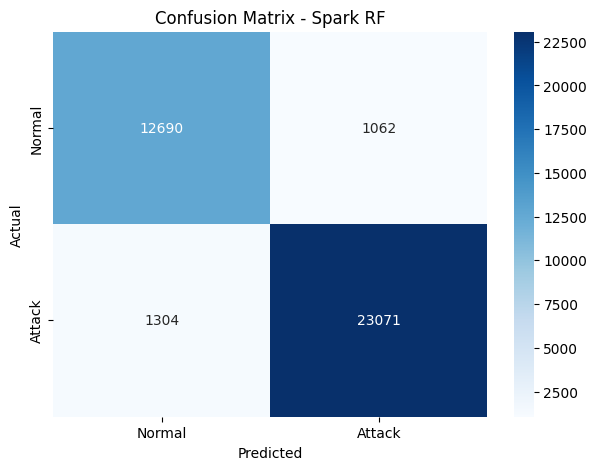

In [4]:
def evaluate_spark_model(model, test_data):
    print("\nFINAL EVALUATION: UNSEEN TEST DATA (SPARK)")

    # --- FIX: Drop columns if they exist to prevent "already exists" error ---
    # This allows the model's internal pipeline to create them fresh
    cols_to_drop = ["proto_idx", "service_idx", "state_idx", "label_target", "features"]
    for c in cols_to_drop:
        if c in test_data.columns:
            test_data = test_data.drop(c)
    # -----------------------------------------------------------------------

    # Make predictions
    predictions = model.transform(test_data)

    # Convert to RDD for MulticlassMetrics
    # Note: RFormula inside the model creates 'label_target'
    predictionAndLabels = predictions.select(
        col("prediction").cast(FloatType()),
        col("label_target").cast(FloatType())
    ).rdd

    metrics = MulticlassMetrics(predictionAndLabels)

    # Overall (Weighted) Metrics
    print(f"\n--- OVERALL PERFORMANCE (Weighted) ---")
    print(f"Accuracy:           {metrics.accuracy:.6f}")
    print(f"Weighted Precision: {metrics.weightedPrecision:.6f}")
    print(f"Weighted Recall:    {metrics.weightedRecall:.6f}")
    print(f"Weighted F1-Score:  {metrics.weightedFMeasure():.6f}")

    # Confusion Matrix
    cm = metrics.confusionMatrix().toArray()
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Spark RF')
    plt.show()

# EXECUTION CALL
# Since the function is now "safe", you can pass either test_df or test_indexed
evaluate_spark_model(best_rf_model, test_df)